# 0. Dependency

```
pandas
numpy
matplotlib
urlib
os
python
torch
tranformers
unicodedata
tqdm
gc
random
itertools
```

This project needs many GPU resource to train model. (Insufficient with colab)

So, you would better prepare GPU environments.

Also it is for gpu version. 

Despite of my recommendation, want to run at CPU -> you should fix the code yourself.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os

In [ ]:
# Make dir to save data
# Ouput : /content/drive/MyDrive/nsmc
try:
  if not os.path.exists('./nsmc'):
    os.makedirs('./nsmc')
except OSError:
  print("Error: Failed to create the directory.")

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="./nsmc/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="./nsmc/ratings_test.txt")

('./nsmc/ratings_test.txt', <http.client.HTTPMessage at 0x7f558c6ab4c0>)

# 1. Load Dataset

In [ ]:
# Read dataframe via pandas
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print(f"train_data nums : {len(train_data)}")
train_data.head()

train_data nums : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print(f"test_data nums : {len(test_data)}")
test_data.head()

test_data nums : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 2-1. Data Preoprocess
## Train_data
### Remove Duplicate

In [ ]:
# Check duplicate

print(f"Unique documents num: {train_data['document'].nunique()}")
print(f"Duplicated documents num : {len(train_data)-train_data['document'].nunique()}")

# Remove duplicates

train_data.drop_duplicates(subset=['document'], inplace=True)

Unique documents num: 146182
Duplicated documents num : 3818


### Remove Null

In [ ]:
# Check null data

print(f"IsNull : {train_data.isnull().values.any()}")
print(f"Null train_data : {len(train_data.loc[train_data.document.isnull()])}\n")
print(train_data.loc[train_data.document.isnull()])

# Remove null data

train_data = train_data.dropna(how = 'any')

IsNull : True
Null train_data : 1

            id document  label
25857  2172111      NaN      1


### Remove exclamation mark with Regular Expression

We can remove exclamarion mark using regular expression

Constant range : ㄱ ~ ㅎ -> 3131 ~ 314E
Vowel range : ㅏ ~ ㅣ -> 314F ~ 3163\
(https://www.unicode.org/charts/PDF/U3130.pdf)

Complete Korean lanuage range : 가 ~ 힣\
https://www.unicode.org/charts/PDF/UAC00.pdf

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-19-9c6253be230d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# Check null data
# Change white space 2 empty space

train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

train_data.loc[train_data.document.isnull()][:5]

id            0
document    398
label         0
dtype: int64


<ipython-input-17-d503e7a00374>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
1312,5831045,NaN,0
1549,7246718,NaN,1


In [ ]:
# Remove null data again

train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


## Test_data
### Remove Duplicate

In [ ]:
# Check duplicate

print(f"Unique test_data documents num: {test_data['document'].nunique()}")
print(f"Duplicated test_data documents num : {len(test_data)-test_data['document'].nunique()}\n")

# Remove duplicates

test_data.drop_duplicates(subset=['document'], inplace=True)

Unique test_data documents num: 49157
Duplicated test_data documents num : 843



### Remove Null

In [ ]:
# Check null data

print(f"IsNull : {test_data.isnull().values.any()}")
print(f"Null train_data : {len(test_data.loc[test_data.document.isnull()])}\n")
print(test_data.loc[test_data.document.isnull()])

# Remove null data

test_data = test_data.dropna(how = 'any')

IsNull : True
Null train_data : 1

          id document  label
5746  402110      NaN      1


### Remove exclamation mark with Regular Expression

In [ ]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

<ipython-input-22-fc68a8c37bd6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [ ]:
# Check null data
# Change white space 2 empty space

test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
print(test_data.isnull().sum())

test_data.loc[test_data.document.isnull()][:5]

id            0
document    305
label         0
dtype: int64


<ipython-input-23-567d926e84b2>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


,id,document,label
1,9274899,NaN,0
116,6910486,NaN,1
254,4976468,NaN,0
468,7517102,NaN,0
504,2096424,NaN,0


In [ ]:
# Remove null data again

test_data = test_data.dropna(how = 'any')
print(len(test_data))

48852


# 2-2. Check Dataset Imbalance

0    73043
1    72350
Name: label, dtype: int64


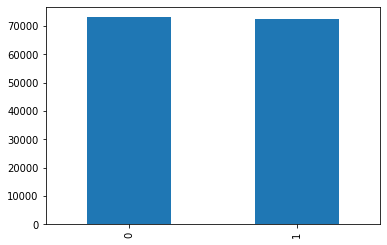

In [ ]:
# Check train_data distribution

train_data['label'].value_counts().plot(kind = 'bar')
print(train_data['label'].value_counts())

1    24520
0    24332
Name: label, dtype: int64


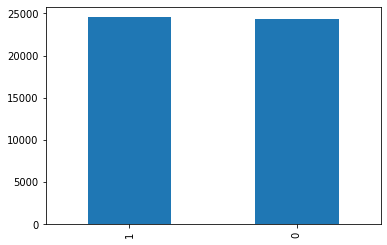

In [ ]:
# Check test_data distribution

test_data['label'].value_counts().plot(kind = 'bar')
print(test_data['label'].value_counts())

Train, Test dataset are well distributed as above.

# 2-3. Padding

Max length of document : 140
Avg length of document : 33.08291320765099


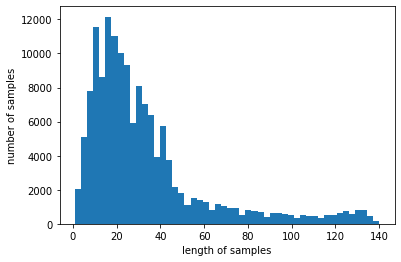

In [ ]:
# Split data, label

X_train = np.array(train_data['document'])
X_test = np.array(test_data['document'])
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# Plot document length distribution

print('Max length of document :',max(len(review) for review in X_train))
print('Avg length of document :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

The length of the longest document is 140, and the length distribution of the entire document has a length of around 20 in general. 

We need to make all samples of X_train and X_test **the same length to a specific length** so that the model can handle it. Then what is **the optimal value for max_len** that will allow most reviews to avoid truncating document information? 

Let's check the ratio of total documents whose length is less than or equal to max_len.

#### Ablation experiment : When we fix the optimal length, is there information lose in documents?

Compare padding -> Optimal length contanining 90%, 95%, 99% / Max length

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print(f'Ratio of doument L = {max_len} : {count / len(nested_list)*100:.2f}')
    return (count / len(nested_list)*100)

Ratio of document which is equal or less than length L in entire document
Ratio of doument L = 1 : 0.18
Ratio of doument L = 2 : 0.71
Ratio of doument L = 3 : 1.42
Ratio of doument L = 4 : 2.47
Ratio of doument L = 5 : 3.54
Ratio of doument L = 6 : 4.94
Ratio of doument L = 7 : 6.49
Ratio of doument L = 8 : 8.30
Ratio of doument L = 9 : 10.30
Ratio of doument L = 10 : 12.68
Ratio of doument L = 11 : 15.36
Ratio of doument L = 12 : 18.25
Ratio of doument L = 13 : 21.22
Ratio of doument L = 14 : 24.17
Ratio of doument L = 15 : 27.07
Ratio of doument L = 16 : 29.82
Ratio of doument L = 17 : 32.53
Ratio of doument L = 18 : 35.14
Ratio of doument L = 19 : 37.68
Ratio of doument L = 20 : 40.11
Ratio of doument L = 21 : 42.46
Ratio of doument L = 22 : 44.75
Ratio of doument L = 23 : 47.01
Ratio of doument L = 24 : 49.16
Ratio of doument L = 25 : 51.33
Ratio of doument L = 26 : 53.41
Ratio of doument L = 27 : 55.43
Ratio of doument L = 28 : 57.47
Ratio of doument L = 29 : 59.39
Ratio of doumen

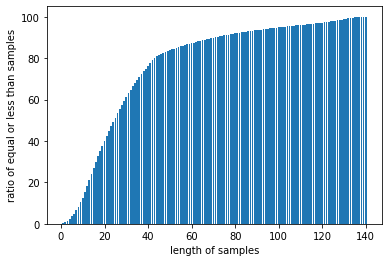

mean : 77.08363342310643, std : 28.064169304173113, var : 787.5975987332923 



In [ ]:
max_len = [i for i in range(1,141)]
ratio = [] 

print('Ratio of document which is equal or less than length L in entire document')
for value in max_len:
    ratio.append(below_threshold_len(value, X_train))

plt.bar(max_len,ratio)
plt.xlabel('length of samples')
plt.ylabel('ratio of equal or less than samples')
plt.show()

print(f"mean : {np.mean(ratio)}, var : {np.var(ratio)}, std : {np.std(ratio)} \n")

**By results of function, we can choose optimal length.**
* 90% : length 70 (89.87502837137964%) 
* 95% : length 100 (94.86426444189198%) 
* 99% : length 130 (98.81493606982454%) 
* 100% : length 140 (100%)

# 3-1. Tokenization

## Use Pretrained model : snunlp/KR-BERT-char16424  from Huggingface
(https://huggingface.co/snunlp/KR-BERT-char16424)

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from transformers import BertConfig, BertModel, BertForPreTraining, BertTokenizer, BertForSequenceClassification
from unicodedata import normalize

tokenizer = BertTokenizer.from_pretrained('snunlp/KR-BERT-char16424', do_lower_case=False)

# Convert a string into sub-char
def to_subchar(string):
    return normalize('NFKD', string)

sentence = '토크나이저 예시입니다.'
print(tokenizer.tokenize(to_subchar(sentence)))

Some weights of the model checkpoint at snunlp/KR-BERT-char16424 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

['ᄐ', '##ᅩ', '##ᄏ', '##ᅳ', '##ᄂ', '##ᅡ', '##ᄋ', '##ᅵ', '##ᄌ', '##ᅥ', 'ᄋ', '##ᅨ', '##ᄉ', '##ᅵ', '##ᄋ', '##ᅵ', '##ᆸ', '##ᄂ', '##ᅵ', '##ᄃ', '##ᅡ', '.']


In [ ]:
# Sample data
text = X_train[1]

# Tokenize sample
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

# Encode sample
input_ids = tokenizer.encode(text)
print(input_ids)

# Decode sample
decoded_ids = tokenizer.decode(input_ids)
print(decoded_ids)

['흠', '##포스', '##터', '##보고', '초', '##딩', '##영화', '##줄', '##오', '##버', '##연', '##기', '##조차', '가', '##볍', '##지', '않', '##구나']
[2, 14091, 7518, 347, 2170, 361, 1973, 3429, 1889, 188, 556, 189, 41, 4589, 72, 9907, 32, 808, 5794, 3]
[CLS] 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나 [SEP]


# 3-2. Pretrained model

In [ ]:
# KR-BERT_model
inputs = tokenizer.batch_encode_plus([text], return_tensors='pt')

model = BertForSequenceClassification.from_pretrained('snunlp/KR-BERT-char16424')

out = model(**inputs)

print(out.loss)
print(out.logits)

None
tensor([[-0.0736, -0.0467]], grad_fn=<AddmmBackward0>)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import torch
from tqdm import tqdm

In [ ]:
#  Returns a bool indicating if CUDA is currently available.
print(f"cuda avaliable : {torch.cuda.is_available()}")
 
#  Returns the index of a currently selected device.
print(f"cuda device num : {torch.cuda.current_device()}")
 
#  Returns the number of GPUs available.
print(f"entire cuda nums : {torch.cuda.device_count()}")
 
#  Gets the name of a device.
print(f"device name : {torch.cuda.get_device_name(0)}")
 
#  Context-manager that changes the selected device.
#  Device (torch.device or int) – device index to select. 
print(torch.cuda.device(0))

cuda avaliable : True
cuda device num : 0
entire cuda nums : 1
device name : Tesla T4


# 3-3. Load dataloader & Fine tuning

In [ ]:
# Naver Sentiment Movie Corpus Dataset
class NsmcDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]
        label = torch.tensor(self.df.iloc[idx, 2])
        return text, label

In [ ]:
# CUDA empty cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Fix random seed
import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

## Hyperparameter selection criteria

KR-BERT is korean language based on BERT.
They experiments sentiment classification for downstream task with NSMC dataset.

We used same fine-tuning hyperparameters in KR-BERT.

Batch size : 32, 64
Epochs : 5 
Learning rate : 1e-3, 2e-5, 5e-5



[KR-BERT paper](https://arxiv.org/abs/2008.03979)

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from itertools import product

# Train

# Hyperparameter
Max_len = [70, 100, 130, 140]
Learning_rate = [1e-3, 2e-5, 5e-5]
batch = 32
epochs = 5
hyperparameter = product(Max_len, Learning_rate)

# Train dataloader
train_dataset = NsmcDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)

for max_len, learning_rate in hyperparameter:

  train_loss = 0
  train_len = 0
  train_correct = 0

  # Set optimizer
  optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  eps=1e-8
                  )

  # Total train steps
  total_steps = len(train_loader) * epochs
  # Learning rate schedular
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0,
                                              num_training_steps = total_steps)

  # CUDA device
  cuda = torch.device('cuda')
  model = model.cuda()

  model.train()
  for epoch in range(epochs):
    
    model.train()

    print(f'======== Epoch {epoch+1} / {epochs} ========')
    # Initalize train loss

    train_loss = 0
    train_len = 0
    train_correct = 0

    
    for text, label in tqdm(train_loader,desc="train"):
      optimizer.zero_grad()
      
      # Encoding and zero padding
      feature = tokenizer.batch_encode_plus(text, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
      
      feature, label = feature.to(device=cuda), label.to(device=cuda)

      # Forward
      outputs = model(**feature, labels=label)

      logits = outputs['logits']
      loss = outputs['loss']

      # Get loss
      pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
      correct = pred.eq(label)

      train_correct += correct.sum().item()
      train_len += len(label)
      train_loss += loss.item()

      # Update gradient
      loss.backward()

      optimizer.step()
      scheduler.step()
    print('Train accuracy: ', (train_correct / train_len)*100)
    

    # Save model    
    model_name = "model"+ "_" + str(max_len) + "_" +str(epoch) + ".pt"
    PATH='./nsmc'
    torch.save(model.state_dict(), os.path.join(PATH, model_name))

    # Save log
    log_file_curve = open(os.path.join(PATH, 'log_curve.txt'), 'a+')
    log_file_curve.write(str(epoch) + ',' + str(train_loss/train_len) + ',' + str(max_len) +',' + str(learning_rate) + '\n')
    log_file_curve.close()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 5 ========


train: 100%|██████████| 4544/4544 [28:32<00:00,  2.65it/s]


Train accuracy:  86.31158308859436
======== Epoch 2 / 5 ========


train: 100%|██████████| 4544/4544 [28:32<00:00,  2.65it/s]


Train accuracy:  91.33039417303446
======== Epoch 3 / 5 ========


train: 100%|██████████| 4544/4544 [28:26<00:00,  2.66it/s]


Train accuracy:  94.66824400074282
======== Epoch 4 / 5 ========


train: 100%|██████████| 4544/4544 [28:37<00:00,  2.65it/s]


Train accuracy:  96.83891246483668
======== Epoch 5 / 5 ========


train:  38%|███▊      | 1746/4544 [10:57<19:47,  2.36it/s]


======== Epoch 1 / 5 ========\
train: 100%|██████████| 4544/4544 [28:32<00:00,  2.65it/s]\
Train accuracy:  86.31158308859436\
======== Epoch 2 / 5 ========\
train: 100%|██████████| 4544/4544 [28:32<00:00,  2.65it/s]\
Train accuracy:  91.33039417303446\
======== Epoch 3 / 5 ========\
train: 100%|██████████| 4544/4544 [28:26<00:00,  2.66it/s]\
Train accuracy:  94.66824400074282\
======== Epoch 4 / 5 ========\
train: 100%|██████████| 4544/4544 [28:37<00:00,  2.65it/s]\
Train accuracy:  96.83891246483668\
======== Epoch 5 / 5 ========


# 4. Test model

In [ ]:
# Test

# Test dataloader
test_dataset = NsmcDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=2)


test_loss = 0
test_len = 0
test_correct = 0

model.eval()

for text, label in tqdm(test_loader,desc="test"):
  # Encoding and zero padding
  feature = tokenizer.batch_encode_plus(text, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
  
  feature, label = feature.to(device=cuda), label.to(device=cuda)
  
  # Forward
  outputs = model(**feature, labels=label)

  logits = outputs['logits']
  loss = outputs['loss']
  
  # Get accuracy
  pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
  correct = pred.eq(label)

  test_correct += correct.sum().item()
  test_len += len(label)
  test_loss += loss.item()

print('Test accuracy: ', (test_correct / test_len)*100)

In [50]:
# Show files in nsmc dir
os.listdir(PATH)

['model_70_1.pt',
 'model_70_2.pt',
 'model_70_3.pt',
 'model_70_4.pt',
 'model_70_0.pt',
 'model_100_0.pt',
 'model_100_1.pt',
 'model_100_2.pt',
 'model_100_3.pt',
 'log_curve.txt']

In [ ]:
# Load trained model
model_path = './[write your model]'
model = BertForSequenceClassification.from_pretrained('snunlp/KR-BERT-char16424')
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
# Test any sentence

def test_sentences(new_sentence):
    new_sentence = new_sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    new_sentence = tokenizer.batch_encode_plus([new_sentence], return_tensors='pt')
    
    # Predict
    with torch.no_grad():
      outputs = model(**new_sentence)
    
    logits = outputs['logits']
    
    pred = torch.argmax(logits, dim=1)
    score = F.softmax(logits, dim=1)
    score = (score[0][pred]).item()

    # Print result
    if(pred > 0.5):
      print(f"{score * 100:2f}% Positive Review\n")
    else:
      print(f"{score * 100:2f}% Negative Review\n")

In [ ]:
test_sentences('이 영화 꿀잼 ㅋㅋㅋ')
test_sentences('이 영화 노잼 ㅋㅋㅋ')
test_sentences('내가 이걸 좋아할거 같냐?ㅋㅋㅋ')